In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Ball by Ball Data
#ball_by_ball_df = pd.read_csv("C:/Users/utkhare/Desktop/Documents/Onwards2015.csv")
ball_by_ball_df = pd.read_csv("C:/Users/utkhare/Desktop/Documents/Onwards2018.csv")

In [3]:
# Match Data (toss, venue, result etc)
match_df = pd.read_csv("C:/Users/utkhare/Desktop/Documents/Match Data 2015 Onwards.csv")

In [4]:
# Goal 
# Group batsmen by the percentage of total team score they contribute to, in wins and losses. 
# If we see some batsmen scoring much more heavily in wins than losses, we know they are the Key to their team's success

In [5]:
# Get Player Total score for each Match
player_scores = ball_by_ball_df.groupby(['id' ,'batsman','batting_team'])['batsman_runs'].sum().reset_index()

In [6]:
#Drop columns from Match Data that are not needed - since we need only match results
match_result = match_df.drop(['city', 'date', 'player_of_match', 'venue', 'neutral_venue', 'team1' , 'team2' , 'toss_winner' , 'toss_decision', 'result' , 'result_margin', 'eliminator' , 'method' , 'umpire1' , 'umpire2'] , axis=1)

In [7]:
# Combine DFs to add the winning team's name to each match
player_scores = player_scores.merge(match_result,  on = 'id', how = 'left')

In [8]:
#debug
player_scores.head()

,id,batsman,batting_team,batsman_runs,winner
0,1136561,AT Rayudu,Chennai Super Kings,22,Chennai Super Kings
1,1136561,DJ Bravo,Chennai Super Kings,68,Chennai Super Kings
2,1136561,DL Chahar,Chennai Super Kings,0,Chennai Super Kings
3,1136561,E Lewis,Mumbai Indians,0,Chennai Super Kings
4,1136561,HH Pandya,Mumbai Indians,22,Chennai Super Kings


In [9]:
# Get Total runs scored off the bat by the team in each match
# These are only the runs scored off the bat. Not The total runs scored by the team (which includes extras)
team_scores_per_match = player_scores.groupby(['id', 'batting_team'])['batsman_runs'].sum().reset_index()
team_scores_per_match.rename(columns={"batsman_runs": "team_runs"}, inplace=True)

In [10]:
# debug
team_scores_per_match.head()

,id,batting_team,team_runs
0,1136561,Chennai Super Kings,162
1,1136561,Mumbai Indians,161
2,1136562,Delhi Capitals,160
3,1136562,Kings XI Punjab,166
4,1136563,Kolkata Knight Riders,164


In [11]:
# Combine the two DFs to add total team score next to each batsman
player_scores = player_scores.merge(team_scores_per_match, on = ['id', 'batting_team'], how = 'left')

In [12]:
# Set a result column. If the batsman's team wins , set to True.
player_scores['result'] = (player_scores['batting_team'] == player_scores['winner'])
player_scores['run_percentage'] = 100 * player_scores['batsman_runs'] / player_scores['team_runs']

# Cleanup columns we don't need anymore 
player_scores = player_scores.drop(['batting_team', 'winner'], axis=1)

In [13]:
# debug
player_scores.head(10)

,id,batsman,batsman_runs,team_runs,result,run_percentage
0,1136561,AT Rayudu,22,162,True,13.580247
1,1136561,DJ Bravo,68,162,True,41.975309
2,1136561,DL Chahar,0,162,True,0.000000
3,1136561,E Lewis,0,161,False,0.000000
4,1136561,HH Pandya,22,161,False,13.664596
5,1136561,Harbhajan Singh,8,162,True,4.938272
6,1136561,Imran Tahir,2,162,True,1.234568
7,1136561,Ishan Kishan,40,161,False,24.844720
8,1136561,KH Pandya,41,161,False,25.465839
9,1136561,KM Jadhav,24,162,True,14.814815


In [14]:
# Get average run contribution for wins or loss for each batsman. 
# Add column for number of innings, to be used for filtering later
player_aggregates = player_scores.groupby(['batsman', 'result']).agg({"run_percentage" : "mean", "id" : pd.Series.nunique}).reset_index()

In [15]:
# rename column to a more meaningful name
player_aggregates.rename(columns={"id": "numInnings"}, inplace=True)

In [16]:
# Filter to remove players who have played less than 20 innings in losses
player_aggregate_losses = player_aggregates[(player_aggregates.numInnings >= 10) & (player_aggregates.result == False)]
player_aggregate_losses = player_aggregate_losses.drop(['result', 'numInnings'], axis=1)

In [17]:
# Filter to remove players who have played less than 20 innings in wins
player_aggregate_wins = player_aggregates[(player_aggregates.numInnings >= 10) & (player_aggregates.result == True)]
player_aggregate_wins = player_aggregate_wins.drop(['result', 'numInnings'], axis=1)

In [18]:
# debug
player_aggregate_losses.head()

,batsman,run_percentage
5,AB de Villiers,19.162953
11,AD Russell,15.824246
13,AJ Finch,14.814914
19,AM Rahane,15.487463
21,AR Patel,9.262285


In [19]:
# debug
player_aggregate_wins.head()

,batsman,run_percentage
6,AB de Villiers,28.372239
12,AD Russell,14.492402
14,AJ Finch,11.497183
20,AM Rahane,16.090430
22,AR Patel,4.800050


In [20]:
# Combine back the two DFs to have a unified view for a batsman 
# First column - average run contribution in wins 
# Second Column - average run contribution in losses
player_final_aggregates = player_aggregate_wins.merge(player_aggregate_losses,  on = 'batsman', how = 'left')

In [21]:
# debug 
player_final_aggregates.head()

,batsman,run_percentage_x,run_percentage_y
0,AB de Villiers,28.372239,19.162953
1,AD Russell,14.492402,15.824246
2,AJ Finch,11.497183,14.814914
3,AM Rahane,16.090430,15.487463
4,AR Patel,4.800050,9.262285


In [22]:
# Filter out players contributing less than 12% of team runs consistently
player_final_aggregates = player_final_aggregates[(player_final_aggregates.run_percentage_x >= 12) & (player_final_aggregates.run_percentage_y >=12)]

In [23]:
player_final_aggregates = player_final_aggregates.reset_index()

In [27]:
# debug 
player_final_aggregates

,index,batsman,run_percentage_x,run_percentage_y
0,0,AB de Villiers,28.372239,19.162953
1,1,AD Russell,14.492402,15.824246
2,3,AM Rahane,16.090430,15.487463
3,5,AT Rayudu,20.368779,15.882166
4,6,BA Stokes,14.639213,12.116988
5,7,CA Lynn,17.982348,20.391390
6,8,CH Gayle,26.860912,19.526735
7,9,DA Warner,28.514932,27.765786
8,11,F du Plessis,22.385785,20.132571
9,12,HH Pandya,12.494806,15.555878


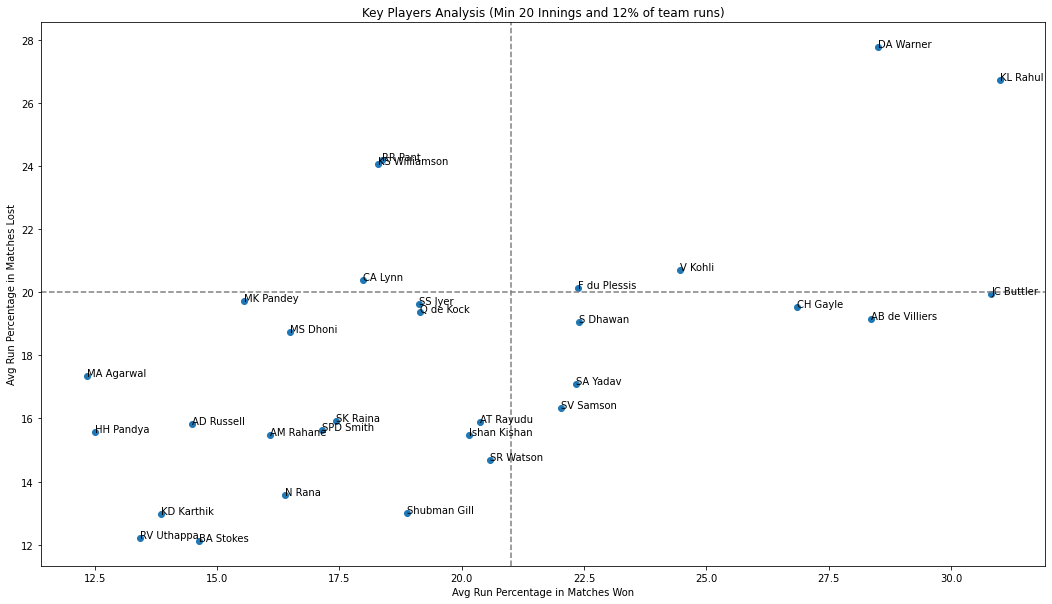

In [25]:
# Plot for Run Contribution in Wins vs Run Contribution in losses
plt.figure(figsize = (18,10))
plt.scatter(player_final_aggregates.run_percentage_x, player_final_aggregates.run_percentage_y)
for i in range(len(player_final_aggregates)): 
    plt.text(player_final_aggregates['run_percentage_x'][i], player_final_aggregates['run_percentage_y'][i], player_final_aggregates['batsman'][i])

plt.axvline(21 , ls = '--', color = 'grey')
plt.axhline(20 , ls = '--', color = 'grey')

plt.title("Key Players Analysis (Min 20 Innings and 12% of team runs)")
plt.xlabel("Avg Run Percentage in Matches Won")
plt.ylabel("Avg Run Percentage in Matches Lost")
plt.show()

In [26]:
# Conclusion

# These players have cleared the filter of atleast 20 innings and atleast 12% of team runs in win AND loss. 
# 12% of total team runs is not a small amount to be scoring consistently,  win or lose. 
# This has resulted in some of the top IPL players showing up in the list. 
# The Chart above is only an attempt to group the best players into their imporance and roles within their teams

# How to read the above chart -: 
# This differentiation below just groups them into different kinds of batsmen and the kind of teams they have played for. 
# The Chart should not be read as any player being detrimental to their team's chances of winning.

# 1. The players in the top right quadrant are consistent, their team contribution is very high irrespective of the final result

# 2. The players in the bottom left quadrant are also consistent, but their team contribution is not very high. This can happen 
#    when you bat lower down the order, or are part of an excellent team where multiple players contribute 

# 3. The players in the top left quadrant, score more heavily in losses than in wins. This is mostly workmen like players, 
#    who have to shoulder the burden after the best in the team fall

# 4. The players in the bottom right quadrant, score more heavily in wins than in losses. Looking from the opposition's 
#    perspective, it should mean if you get these players cheaply your chances of win should shoot up drastically. 